In [12]:
from brownpy.gpu_sim import Universe
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/gallery/axes_grid1/inset_locator_demo.html
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
import cupy as cp
import numpy as np
from tqdm.auto import tqdm
plt.style.use('dark_background')

In [2]:
dt = int(1E6) #fs (1ns) - time steps
D = 1.5E-4 # A²/fs  (1.5E-9 m²/s) - Diffusion coefficient

# Geometry
L = 1E3 # A (100nm) - channel length
h = 1E2 # A (10nm)  - channel height
R = 1E4 # A (1um) - reservoir size

N= 16*1024

In [3]:
u = Universe(N=N, L=L, h=h, R=R, D=D, dt=dt,
             output_path='simu')

simu.hdf5 already exists, change output filename for simu_2.hdf5


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>)

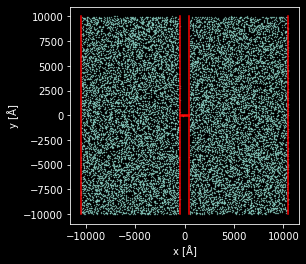

In [4]:
u.plotPosition()

In [5]:
u.run(100_000, freq_dumps=10);

100%|██████████| 100000/100000 [00:07<00:00, 13106.86it/s, total=100 µs]

With 16384 particles
------------------------------------------
GPU time per step:
Allocation: 26.9 µs
Engine: 7.2 µs
Transfert to RAM: 42.2 µs
Total: 76.3 µs
------------------------------------------
CPU time per step:
Other: 36.3 µs
Transfert to drive: 40 µs
Total: 76.3 µs


In [6]:
data = u[0]

Reading region_0 ...
... Done
Reading trajectory ...
... Done


In [7]:
trajectory = data['trajectory']

(-1000.0, 1000.0)

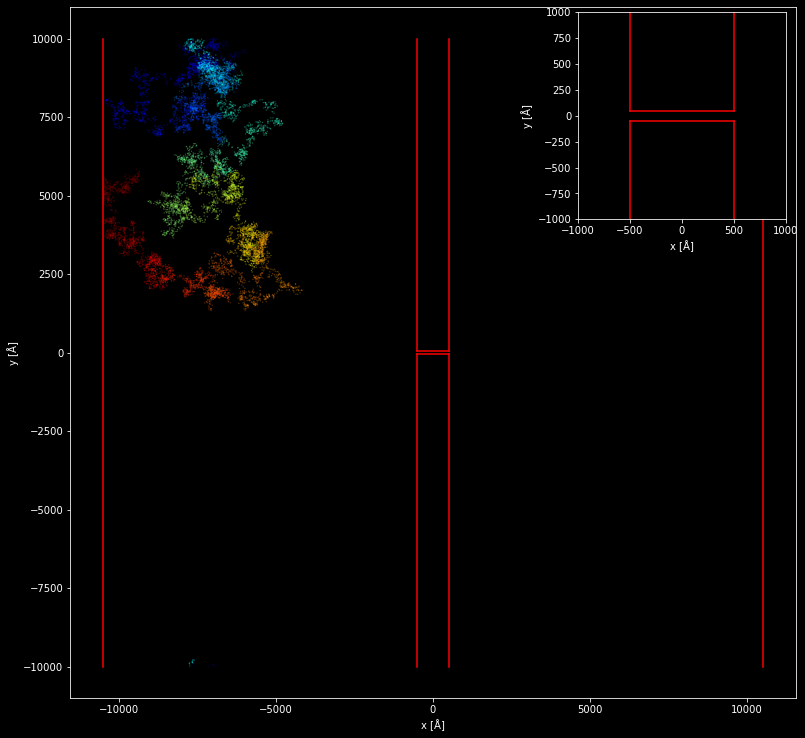

In [18]:
# Get particles that go inside the channel
# i_particle=1107
fig, ax1 = plt.subplots(figsize=(13,13))
ax1_in = inset_axes(ax1, width="30%", height="30%", loc=1)

# ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:])
temp = np.argsort(np.sum(np.abs(trajectory[:,0,:-2])<L/2, axis=1))[::-1]
i_particle = temp[0]
for ax in [ax1, ax1_in]:
        ax.scatter(trajectory[i_particle,0,:], trajectory[i_particle,1,:], 
           c=np.arange(trajectory.shape[2]), marker='.', cmap='jet', s=0.1)
        # for i_particle in temp[:1]:
        #         ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:])

        # for i_particle in range(trajectory.shape[0]):
        #         ax.plot(trajectory[i_particle,0,:2], trajectory[i_particle,1,:2])
        border_kwargs = {'c': 'r'}
        ax.plot([-L/2-R, -L/2-R], [-R, +R], **border_kwargs)
        ax.plot([ L/2+R,  L/2+R], [-R, +R], **border_kwargs)

        ax.plot([-L/2, -L/2], [R, h/2], **border_kwargs)
        ax.plot([+L/2, +L/2], [R, h/2], **border_kwargs)
        ax.plot([-L/2, +L/2], [h/2, h/2], **border_kwargs)
        ax.plot([-L/2, +L/2], [-h/2, -h/2], **border_kwargs)
        ax.plot([-L/2, -L/2], [-R, -h/2], **border_kwargs)
        ax.plot([+L/2, +L/2], [-R, -h/2], **border_kwargs)
        ax.set_xlabel('x [Å]')
        ax.set_ylabel('y [Å]')
        ax.set_aspect('equal')
ax1_in.set_xlim(-1000,1000)
ax1_in.set_ylim(-1000,1000)


In [13]:
u.run2(1_000_000);



With 8192 particles
GPU time per step:
cp.zeros: 0.004 us
cp.random.normal: 2.819 us
engine: 0.001 us
Total: 2.824 us
Need 2.82s to compute 1ms of simulation


In [8]:
import cupy as cp
def PSD_gpu(x, dt):
    x_gpu = cp.asarray(x)
    psd = (cp.abs(cp.fft.rfft(x_gpu))**2).get()
    freqs = (cp.fft.rfftfreq(x.size, dt)).get()
    del x_gpu
    cp._default_memory_pool.free_all_blocks()
    return psd, freqs

def PSD_gpu_binned(x, dt, bins):
    x_gpu = cp.asarray(x)
    psd_gpu = cp.abs(cp.fft.rfft(x_gpu))**2
    freqs_gpu = cp.fft.rfftfreq(x.size, dt)

    psd_binned_gpu, freqs_binned_gpu = cp.histogram(cp.log(freqs_gpu)[1:], 
                                        weights=psd_gpu[1:], bins=bins)
    N_binned_gpu = cp.histogram(cp.log(freqs_gpu)[1:], bins=bins)[0]
    psd_averaged = (psd_binned_gpu/N_binned_gpu).get()
    freqs = ((freqs_binned_gpu[1:]+freqs_binned_gpu[:-1])/2.).get()
    
    del x_gpu, psd_gpu, freqs_gpu, psd_binned_gpu, freqs_binned_gpu, N_binned_gpu
    cp._default_memory_pool.free_all_blocks()
    return psd_averaged, np.exp(freqs)

In [8]:
data = u[0]

Reading region_0 ...
... Done


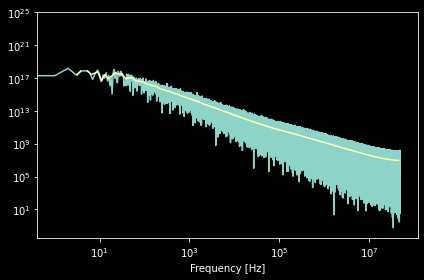

In [9]:
region_0 = data['region_0']
fig, ax = plt.subplots()
psd, freqs = PSD_gpu(region_0[::10], dt*10)
ax.loglog(freqs*1E15, psd)
psd_bin, freqs_bin = PSD_gpu_binned(region_0[::10], dt*10, bins=100)
ax.loglog(freqs_bin*1E15, psd_bin)
ax.set_xlabel('Frequency [Hz]')
fig.tight_layout()

In [9]:
-108%200-100

-8

In [23]:
a = 150
a = (100+a)%200-100
a

-50

In [17]:
(100-98)%200-100

-98